In [1]:
%load_ext autoreload
%autoreload 2

import sys
import copy
import math
import pickle

sys.path.append("../../")

import numpy as np
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

#torch.set_num_threads(6)
torch.set_default_tensor_type(torch.FloatTensor)

In [2]:
epsilon = .5
a = 10.
b = 1.
d = 1.
c = 41.
c0 = 40.
shape_rigid0 = torch.tensor([[0., 0.], [c0, 0.], [c0, a], [0., a], [0., 0.]])
shape_growth0 = torch .tensor([[0., a], [c0, a], [c0, a + b], [0., a + b], [0., a]])

shape_rigid = torch.tensor([[-epsilon, -epsilon], [c + epsilon, -epsilon], [c + epsilon, a +epsilon], [- epsilon, a + epsilon], [-epsilon, -epsilon]])
shape_growth = torch .tensor([[-epsilon, a-epsilon + d], [c+epsilon, a-epsilon + d], [c+epsilon, a + b+epsilon + d], [-epsilon, a + b+epsilon + d], [-epsilon, a-epsilon + d]])


In [3]:
Nh = 40
Nvr = 10
Nvg = 2
Xr0 = torch.stack([torch.linspace(0., c0, Nh), torch.zeros([Nh])]).t()
Xr1 = torch.stack([torch.linspace(c0, 0., Nh), torch.zeros([Nh]) + a]).t()
Yr0 = torch.stack([torch.zeros([Nvr]) + c0, torch.linspace(0., a, Nvr)]).t()
Yr1 = torch.stack([torch.zeros([Nvr]), torch.linspace(a, 0., Nvr)]).t()

Xg0 = torch.stack([torch.linspace(0., c0, Nh), torch.zeros([Nh]) + a]).t()
Xg1 = torch.stack([torch.linspace(c0, 0., Nh), torch.zeros([Nh]) + a + b]).t()
Yg0 = torch.stack([torch.zeros([Nvr]) + c0, torch.linspace(a, a + b, Nvr)]).t()
Yg1 = torch.stack([torch.zeros([Nvr]), torch.linspace(a + b, a, Nvr)]).t()

shape_rigid0 = torch.cat([Xr0, Yr0, Xr1, Yr1], dim=0)
shape_growth0 = torch.cat([Xg0, Yg0, Xg1, Yg1], dim=0)

(-2.6, 43.6, -1.15, 13.15)

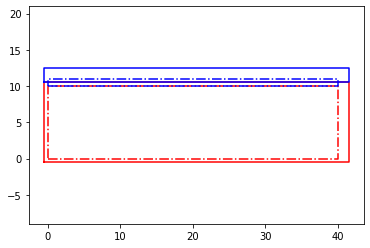

In [4]:
plt.figure()
plt.plot(shape_rigid[:,0], shape_rigid[:,1 ], '-r')
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-.r')
plt.plot(shape_growth[:,0], shape_growth[:,1 ], '-b')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-.b')
plt.axis('equal')

In [5]:
aabb_rigid = dm.Utilities.AABB.build_from_points(shape_rigid)
aabb_growth = dm.Utilities.AABB.build_from_points(shape_growth)

In [6]:
density_rigid = 0.5
density_growth = 0.5

pts_rigid = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_rigid, density_rigid, shape=shape_rigid, side=1)
print(pts_rigid.shape)
pts_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_growth, density_growth, shape=shape_growth, side=1)
print(pts_growth.shape)

torch.Size([240, 2])
torch.Size([60, 2])


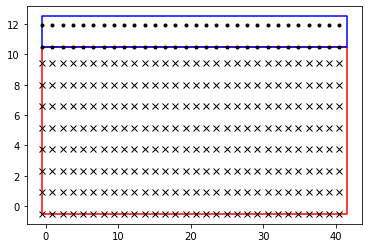

In [7]:
plt.figure()
plt.plot(shape_rigid[:,0], shape_rigid[:,1 ], '-r')
plt.plot(shape_growth[:,0], shape_growth[:,1 ], '-b')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], 'xk')
plt.plot(pts_growth[:,0], pts_growth[:,1], '.k')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

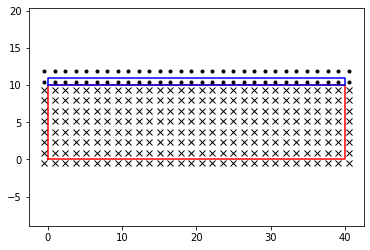

In [8]:
#%matplotlib qt5
plt.figure()
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], 'xk')
plt.plot(pts_growth[:,0], pts_growth[:,1], '.k')
plt.axis('equal')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

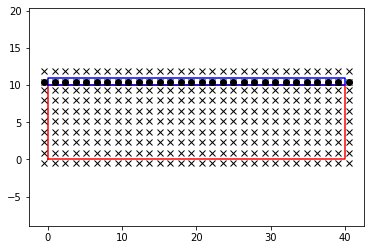

In [9]:
N_rigid = pts_rigid.shape[0]
N_growth = pts_growth.shape[0]
pts_implicit1 = torch.cat([pts_rigid, pts_growth], dim=0)
plt.figure()
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], 'xk')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
plt.plot(pts_implicit1[N_rigid::2,0], pts_implicit1[N_rigid::2,1], 'ok')
plt.axis('equal')

In [10]:
import math

Npers = [1, 2]
Npers = [2]
dimC = len(Npers)
C = torch.zeros(pts_implicit1.shape[0], 2, len(Npers))

for i in range(len(Npers)):
    Nper = Npers[i]
    theta = Nper * torch.linspace(0, 2 * math.pi, int(0.5 * N_growth))
    C[N_rigid::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])
    C[N_rigid+1::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])

In [11]:
C.shape

torch.Size([300, 2, 1])

In [12]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], 'xk')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
dm.Utilities.plot_C_ellipse(ax_left, pts_implicit1, C, c_index=0, scale=0.5, color='red')
plt.axis('equal')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

In [12]:
angles = 0. * math.pi * torch.ones(pts_implicit1.shape[0])
R = torch.stack([dm.Utilities.rot2d(a) for a in angles])

In [13]:
cotan_pts = torch.zeros_like(pts_implicit1)
mm = 5000.
cotan_pts[-1, 0] = mm
cotan_pts[N_rigid + 1, 0] = -mm
#cotan_pts = 200 * (torch.rand_like(pts_implicit1) - 0.7)
cotan_R = torch.zeros_like(R)

In [14]:
sigma1 = 3.
nu = 0.001
implicit1 = dm.DeformationModules.create_deformation_module('implicit_order_1', dim=2, nb_pts=pts_implicit1.shape[0], C=C, sigma=sigma1, nu=nu, coeff=1., gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()), cotan = (cotan_pts.view(-1).requires_grad_(), cotan_R.view(-1).requires_grad_()))

In [15]:
silent_imp = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=pts_implicit1.shape[0], gd=pts_implicit1.view(-1).requires_grad_())
silent_rigid = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_rigid0.shape[0], gd=shape_rigid0.view(-1).requires_grad_())
silent_growth = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_growth0.shape[0], gd=shape_growth0.view(-1).requires_grad_())

In [16]:
intermediate_states, intermediate_controls = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([implicit1, silent_rigid, silent_growth]), 10, 'euler', intermediates=True)
pts = implicit1.manifold.gd[0].detach().view(-1, 2)
pts_rigid = silent_rigid.manifold.gd.detach().view(-1, 2)
pts_growth = silent_growth.manifold.gd.detach().view(-1, 2)

In [17]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], '-r')
plt.plot(pts_growth[:,0], pts_growth[:,1], '-b')
plt.quiver(pts_implicit1[:,0], pts_implicit1[:,1], cotan_pts[:,0], cotan_pts[:,1])
plt.plot(pts[:,0], pts[:,1], '+r')
#plt.plot(pts_imp[:,0], pts_imp[:,1], 'xk')
plt.axis('equal')

(-6.117898678779602,
 46.13002893924713,
 -1.4300320625305176,
 15.451258945465089)

In [18]:
print(intermediate_controls)

[[tensor([1.3382]), tensor([]), tensor([])], [tensor([1.3024]), tensor([]), tensor([])], [tensor([1.2849]), tensor([]), tensor([])], [tensor([1.2860]), tensor([]), tensor([])], [tensor([1.3048]), tensor([]), tensor([])], [tensor([1.3374]), tensor([]), tensor([])], [tensor([1.3716]), tensor([]), tensor([])], [tensor([1.3993]), tensor([]), tensor([])], [tensor([1.4469]), tensor([]), tensor([])], [tensor([1.5476]), tensor([]), tensor([])]]


In [20]:
t = 0
h = intermediate_controls[t][0]
C_t = torch.tensordot(C, h, dims=1).view(-1, 2, 1)

X = intermediate_states[t].gd[0][0].view(-1,2)

In [21]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
#plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(X[:,0], X[:,1], 'xk')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
dm.Utilities.plot_C_ellipse(ax_left, X, C_t, c_index=0, scale=1., color='red')
plt.axis('equal')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

In [19]:
# Source/target : implicit points
target_noisefree = implicit1.manifold.gd[0].detach().view(-1, 2)
source_pts = pts_implicit1.clone()
target_pts = target_noisefree #+ 0.2*torch.rand(*target_noisefree.shape)

In [23]:
# Source/target : surrounding shape
target_noisefree = torch.cat([pts_rigid.clone(), pts_growth.clone()], dim=0)
source_pts = torch.cat([shape_rigid0.clone(), shape_growth0.clone()], dim=0)
target_pts = target_noisefree + 0.2*torch.rand(*target_noisefree.shape)

In [21]:
target_noisefree.shape

torch.Size([300, 2])

In [22]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
plt.plot(target_noisefree[:,0], target_noisefree[:,1], '.r')
plt.plot(target_pts[:,0], target_pts[:,1], '+r')
plt.axis('equal')

(-4.8469722986221315,
 44.859150242805484,
 -5.066342496871949,
 16.96825804710388)

In [20]:
Npers_opt = [1, 2]
dimC_opt = len(Npers)
C_opt = torch.zeros(pts_implicit1.shape[0], 2, len(Npers_opt))

for i in range(len(Npers_opt)):
    Nper = Npers_opt[i]
    theta = Nper * torch.linspace(0, 2 * math.pi, int(0.5 * N_growth))
    C_opt[N_rigid::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])
    C_opt[N_rigid+1::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])

In [21]:
implicit1_opt = dm.DeformationModules.create_deformation_module('implicit_order_1', dim=2, nb_pts=pts_implicit1.shape[0], C=C_opt, sigma=sigma1, nu=nu, coeff=1., gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()))

In [22]:
#implicit0_opt = dm.DeformationModules.create_deformation_module('implicit_order_0', dim=2, nb_pts=pts_implicit1.shape[0], sigma=sigma1, nu=nu, coeff=10., gd=pts_implicit1.clone().view(-1).requires_grad_())

In [23]:
model = dm.Models.ModelPointsRegistration([source_pts], [implicit1_opt], [dm.Attachment.EuclideanPointwiseDistanceAttachment(weight=1.)], lam=100.)

In [24]:
fitter = dm.Models.ModelFittingScipy(model, 1.)

In [25]:
costs = fitter.fit([target_pts], 30, log_interval=1)

Initial energy = 30571.668
Iteration: 1 
Total energy = 29868.769531 
Attach cost = 29863.968750 
Deformation cost = 4.801285
Iteration: 2 
Total energy = 26712.388672 
Attach cost = 26483.185547 
Deformation cost = 229.203888
Iteration: 3 
Total energy = 24701.707031 
Attach cost = 24043.816406 
Deformation cost = 657.891357
Iteration: 4 
Total energy = 21833.423828 
Attach cost = 20295.804688 
Deformation cost = 1537.619385
Iteration: 5 
Total energy = 17124.390625 
Attach cost = 13619.134766 
Deformation cost = 3505.254883
Iteration: 6 
Total energy = 10550.656250 
Attach cost = 5726.289551 
Deformation cost = 4824.366699
Iteration: 7 
Total energy = 8731.635742 
Attach cost = 2992.432129 
Deformation cost = 5739.203613
Iteration: 8 
Total energy = 7263.859375 
Attach cost = 1219.074341 
Deformation cost = 6044.785156
Iteration: 9 
Total energy = 6642.991699 
Attach cost = 493.442200 
Deformation cost = 6149.549316
Iteration: 10 
Total energy = 6179.342773 
Attach cost = 178.888885 

In [26]:
compound = dm.DeformationModules.CompoundModule(model.modules)
compound.manifold.fill(model.init_manifold)

In [27]:
intermediate_states_opt, intermediate_controls_opt = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(compound), 10, 'euler', intermediates=True)

In [28]:
pts = compound.manifold.gd[0].detach().view(-1, 2)

In [35]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
#plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
#plt.plot(pts_rigid[:,0], pts_rigid[:,1], '-r')
#plt.plot(pts_growth[:,0], pts_growth[:,1], '-b')
#plt.quiver(pts_implicit1[:,0], pts_implicit1[:,1], cotan_pts[:,0], cotan_pts[:,1])
plt.plot(pts[:,0], pts[:,1], '+r')
#plt.plot(target_pts[:,0], target_pts[:,1], 'xk')
plt.plot(target_noisefree[:,0], target_noisefree[:,1], 'xb')


plt.axis('equal')

(-4.8469722986221315,
 44.859150242805484,
 -5.06690731048584,
 16.980119132995604)

In [29]:
print(intermediate_controls_opt)

[[tensor([]), tensor([-0.0474,  1.4573])], [tensor([]), tensor([-0.0217,  1.4625])], [tensor([]), tensor([-0.0023,  1.4579])], [tensor([]), tensor([0.0100, 1.4413])], [tensor([]), tensor([0.0150, 1.4116])], [tensor([]), tensor([0.0139, 1.3700])], [tensor([]), tensor([0.0101, 1.3224])], [tensor([]), tensor([0.0079, 1.2762])], [tensor([]), tensor([0.0090, 1.2352])], [tensor([]), tensor([0.0133, 1.2005])]]


In [30]:
print(intermediate_controls)

[[tensor([1.3382]), tensor([]), tensor([])], [tensor([1.3024]), tensor([]), tensor([])], [tensor([1.2849]), tensor([]), tensor([])], [tensor([1.2860]), tensor([]), tensor([])], [tensor([1.3048]), tensor([]), tensor([])], [tensor([1.3374]), tensor([]), tensor([])], [tensor([1.3716]), tensor([]), tensor([])], [tensor([1.3993]), tensor([]), tensor([])], [tensor([1.4469]), tensor([]), tensor([])], [tensor([1.5476]), tensor([]), tensor([])]]


In [39]:
t = 2

In [44]:
for t in range(10):
    print('='*10)
    h = intermediate_controls[t][0]
    print(h)
    C_t = torch.tensordot(C, h, dims=1).view(-1, 2, 1)
    h_opt = intermediate_controls_opt[t][1]
    print(h_opt)
    C_opt_t = torch.tensordot(C, h_opt, dims=1).view(-1, 2, 1)

tensor([0.4532, 0.1129])
tensor([0.4559, 0.0920])
tensor([0.4530, 0.1098])
tensor([0.4549, 0.0908])
tensor([0.4528, 0.1054])
tensor([0.4538, 0.0895])
tensor([0.4523, 0.0998])
tensor([0.4527, 0.0880])
tensor([0.4517, 0.0929])
tensor([0.4514, 0.0863])
tensor([0.4509, 0.0849])
tensor([0.4502, 0.0844])
tensor([0.4500, 0.0759])
tensor([0.4488, 0.0823])
tensor([0.4488, 0.0659])
tensor([0.4475, 0.0801])
tensor([0.4475, 0.0552])
tensor([0.4461, 0.0778])
tensor([0.4459, 0.0438])
tensor([0.4447, 0.0754])


In [45]:
torch.max(torch.abs(C_t))

tensor(0.4898)

In [46]:
torch.max(torch.abs(C_t - C_opt_t))

tensor(0.0320)

In [110]:
t = 9
target_t = intermediate_states[t].gd[0][0].view(-1,2)
reached_t = intermediate_states_opt[t].gd[1][0].view(-1,2)

In [112]:
plt.figure()
plt.plot(target_t[:,0], target_t[:,1], '.b')
plt.plot(reached_t[:,0], reached_t[:,1], '.r')
plt.axis('equal')

(-4.149214178323746,
 44.16139867901802,
 -2.2784684121608736,
 14.028443259000777)